# Part 1

## Setup

In [16]:
using Plots
using JuMP, HiGHS

include("utils.jl")

sample_chain (generic function with 1 method)

In [17]:
DATA_DIR = "data/"

"data/"

In [18]:
prices = vec(read_file(DATA_DIR * "belpex_price.txt"))
states = vec(read_file(DATA_DIR * "markov_support_4.txt"))
P_prob = read_file(DATA_DIR * "markov_weights_4.txt")

4×4 Matrix{Float64}:
 0.394106    0.524075   0.0807228  0.00109546
 0.107876    0.564185   0.311323   0.016616
 0.016616    0.311323   0.564185   0.107876
 0.00109546  0.0807228  0.524075   0.394106

## Questions

### 1. Plot the evolution of the given expected price and comment. How can the battery make profit ? How is it useful for the system ?

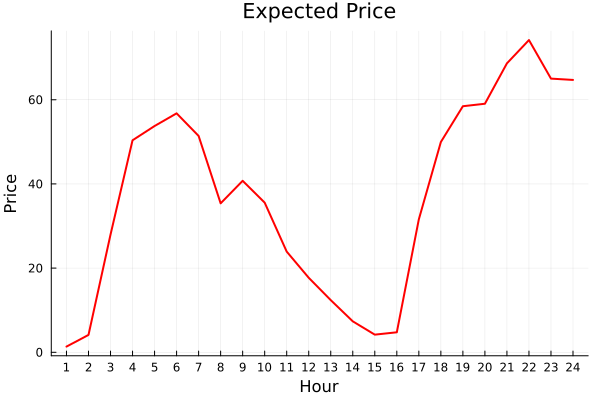

In [19]:
plot(
    1:24, 
    prices, 
    title = "Expected Price",
    xlabel = "Hour",
    ylabel = "Price",
    legend = false,
    xticks = 1:24, 
    color = :red,
    lw = 2)

### 2. Generate 10 different price scenarios over the 24 hours and plot them against the expected price.

In [20]:
N_scenarios = 10

10

In [21]:
xi_t = zeros(N_scenarios, 24)
lambda_t = zeros(N_scenarios, 24)

10×24 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [22]:
for i in 1:N_scenarios
    xi_t[i, :] = sample_chain(24, P_prob, states)
end

In [23]:
for i in 1:N_scenarios
    lambda_t[i, :] = prices .* exp.(xi_t[i, :])
end

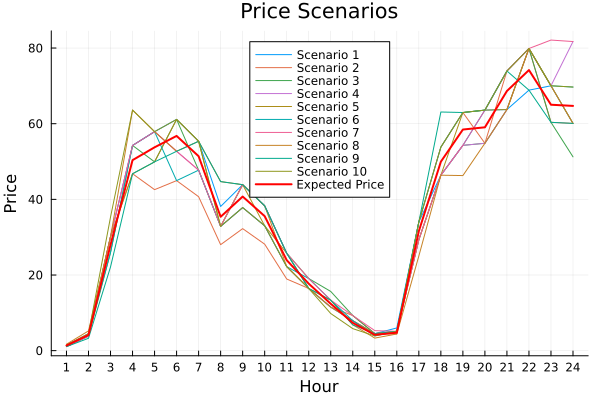

In [24]:
p = plot(
    1:24, 
    eachrow(lambda_t),
    title = "Price Scenarios",
    xlabel = "Hour",
    ylabel = "Price",
    xticks = 1:24,
    label = reshape(["Scenario $i" for i in 1:N_scenarios], 1, N_scenarios),
    legend = :top,
    )

plot!(
    1:24,
    prices, 
    label = "Expected Price",
    color = :red,
    lw = 2,
)



### 3. Formulate the deterministic problem.

The model reads :
$$
\begin{align*}
\max_{b_t, \eta_t, \xi_t}& 0.9\sum_{t=1}^{24} p_t \eta_t - \sum_{t=1}^{24} p_t \xi_t \\
\text{s.t.}~& b_t = b_{t-1} - \eta_t + 0.9\xi_t, \quad t = 1,\dots, 24\\
&0 \leq \eta_t \leq 200,~ 0 \leq \xi_t \leq 200,\quad t = 1,\dots, 24 \\
&0 \leq b_t \leq 800,\quad t = 1,\dots, 24 \\
\end{align*}
$$
where :
* $b_t \equiv$ batery level at time $t$
* $\eta_t \equiv $ discharging at time $t$
* $\xi_t\equiv$ charging at time $t$
* $p_t\equiv $ price at time $t$

In [25]:
deterministic_model = Model(HiGHS.Optimizer)

@variable(deterministic_model, 0 <= b[1:24] <= 800)
@variable(deterministic_model, 0 <= xi[1:24] <= 200)
@variable(deterministic_model, 0 <= eta[1:24] <= 200)

@constraint(deterministic_model,[t in 2:24] ,b[t] == b[t-1] - eta[t] / (0.9) + 0.9 * xi[t])
# @constraint(deterministic_model, b[1] == 0)


@objective(deterministic_model, Max,
    sum(prices[t] * eta[t] for t in 1:24) - sum(prices[t] * xi[t] for t in 1:24)
)

1.35 eta[1] + 4.13 eta[2] + 27.96 eta[3] + 50.37 eta[4] + 53.76 eta[5] + 56.77 eta[6] + 51.4 eta[7] + 35.39 eta[8] + 40.74 eta[9] + 35.55 eta[10] + 23.92 eta[11] + 17.7 eta[12] + 12.39 eta[13] + 7.35 eta[14] + 4.19 eta[15] + 4.75 eta[16] + 31.59 eta[17] + 49.96 eta[18] + 58.46 eta[19] + 59.05 eta[20] + 68.65 eta[21] + 74.18 eta[22] + 65.02 eta[23] + 64.71 eta[24] - 1.35 xi[1] - 4.13 xi[2] - 27.96 xi[3] - 50.37 xi[4] - 53.76 xi[5] - 56.77 xi[6] - 51.4 xi[7] - 35.39 xi[8] - 40.74 xi[9] - 35.55 xi[10] - 23.92 xi[11] - 17.7 xi[12] - 12.39 xi[13] - 7.35 xi[14] - 4.19 xi[15] - 4.75 xi[16] - 31.59 xi[17] - 49.96 xi[18] - 58.46 xi[19] - 59.05 xi[20] - 68.65 xi[21] - 74.18 xi[22] - 65.02 xi[23] - 64.71 xi[24]

### 4. Solve the deterministic model of profit maximization over the 24 hours and plot the evolution of the energy stored in the battery

In [26]:
optimize!(deterministic_model)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 1e+00]
  Cost   [1e+00, 7e+01]
  Bound  [2e+02, 8e+02]
  RHS    [0e+00, 0e+00]
Presolving model
23 rows, 70 cols, 92 nonzeros  0s
23 rows, 70 cols, 92 nonzeros  0s
Presolve : Reductions: rows 23(-0); columns 70(-2); elements 92(-0)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         34    -8.0726266667e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 34
Objective value     :  8.0726266667e+04
HiGHS run time      :          0.00


In [27]:
bt = value.(b)
eta_t = value.(eta)
xi_t = value.(xi)

24-element Vector{Float64}:
   0.0
   0.0
  -0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
 200.0
  -0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

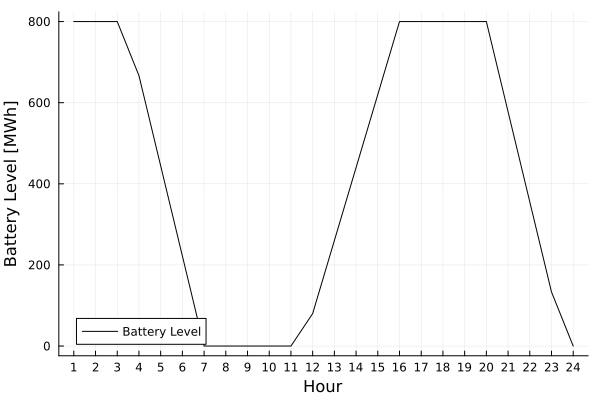

In [28]:
p = plot(
    1:24, 
    bt, 
    label="Battery Level", 
    xlabel="Hour", 
    ylabel="Battery Level [MWh]", 
    color=:black,
    xticks = 1:24,
)


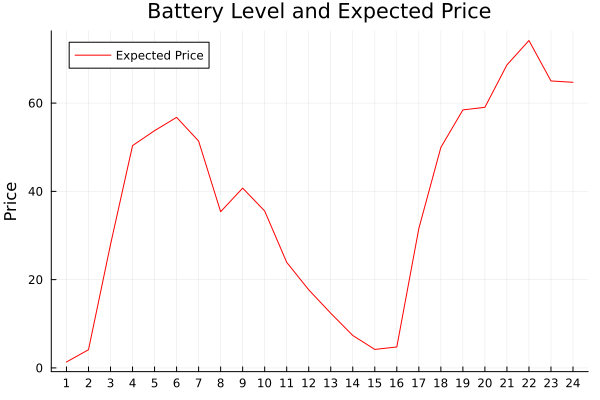

In [29]:
plot(
    1:24, 
    prices, 
    label="Expected Price", 
    ylabel = "Price", 
    color=:red,
    xticks = 1:24,
    title = "Battery Level and Expected Price"
)

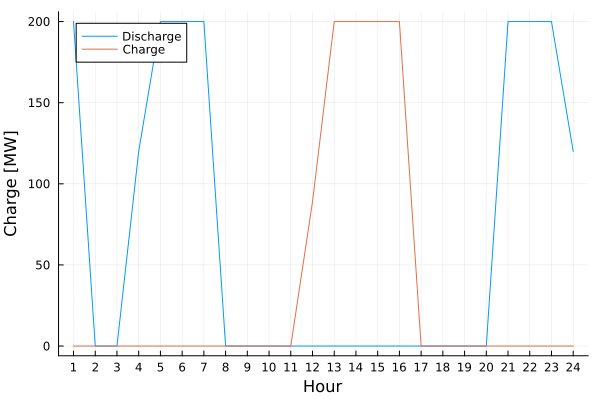

In [32]:
p = plot(
    1:24, 
    [eta_t, xi_t], 
    label = reshape(["Discharge", "Charge"], 1, 2), 
    xlabel="Hour", 
    ylabel="Charge [MW]", 
    xticks = 1:24,
)